In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# import the data covert that into a convenient data
PATH= '/home/ac-optimus/data_science/recommendation_sys/ratings_small.csv'
df = pd.read_csv(PATH, sep= ",")
# df = pd.read_csv(PATH, sep= ",")
df.shape

(100004, 4)

In [3]:
df.drop('timestamp', axis=1, inplace=True)
df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [4]:
# this gave me a good plot
from sklearn.utils import shuffle
df = shuffle(df)

In [5]:
df.head()

,userId,movieId,rating
44654,313,344,2.5
6582,36,382,3.0
1434,15,2302,3.5
41730,299,4552,5.0
40989,294,7373,4.0


In [6]:
num_rows = df.shape[0]
train, test = df.copy(deep = True), df[int(num_rows*0.8):].copy(deep = True)
train[int(num_rows*0.8):]['rating']  = train[int(num_rows*0.8):]['rating']*0
train = shuffle(train)

<ipython-input-6-75ff325d5135>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[int(num_rows*0.8):]['rating']  = train[int(num_rows*0.8):]['rating']*0


In [7]:
user_movie_rating =train.groupby(['userId','movieId'])['rating'].max().unstack().fillna(0)
user_movie_rating.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
user_movie_rating.shape
print ("We have {} users in our user-movie matrix.".format(user_movie_rating.shape[0]))
print ("We have {} movies in our user-movie matrix.".format(user_movie_rating.shape[1]))


We have 671 users in our user-movie matrix.
We have 9066 movies in our user-movie matrix.


In [9]:
correlation_matrix = user_movie_rating.T.corr()
correlation_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.003341,-0.002639,0.048536,0.017164,-0.002223,0.041407,-0.004005,0.013841,-0.002592,...,-0.002840,-0.001980,0.010497,0.017432,-0.002149,-0.002963,-0.001705,-0.002176,-0.002096,0.018623
2,-0.003341,1.000000,0.134555,0.089611,0.066414,-0.004537,0.146243,0.106211,0.094935,0.045026,...,0.438615,0.042914,0.058905,0.111783,0.382658,0.349728,0.071350,0.003028,0.173452,0.092241
3,-0.002639,0.134555,1.000000,0.032615,0.096583,0.052621,0.163870,0.222999,0.081753,0.111750,...,0.136377,0.074478,0.135421,0.142124,0.148166,0.123075,0.149762,0.099601,0.132307,0.103537
4,0.048536,0.089611,0.032615,1.000000,0.100082,0.033740,0.266544,0.136411,-0.008427,0.111331,...,0.053088,0.013190,0.088680,0.161071,0.065986,0.035273,0.037570,0.109878,0.016349,0.175618
5,0.017164,0.066414,0.096583,0.100082,1.000000,0.015129,0.037263,0.151271,0.019530,0.019346,...,0.156231,0.019988,0.117674,0.185500,0.117956,0.041648,0.025474,-0.005210,0.069229,0.163005


In [10]:
def error(y_hat, y):
    # MSE
    y_hat = np.array(y_hat)
    y = np.array(y)
    MSE_ = (y_hat- y)**2
    MSE = MSE_.sum()/len(y_hat)
    return MSE

### Similarity based

In [11]:
def PredictMovieRating(user_i, movie_i, corr_mat, user_movie_rating, k):
    # for user x
    # rxi = sum over knn (sxy*ryi)/sum over all the knn similarities
    all_neighbours = corr_mat.loc[user_i]
    all_neighbours = all_neighbours.drop(user_i)
    topk_neighbours = all_neighbours.sort_values(ascending=False)[:k]  # knn
    # knn user ids
    knn = topk_neighbours.index.tolist()
#     return knn
    sum_sim = sum([corr_mat[user_i][user_j] for user_j in knn])
    weighted_sum_sim = sum([corr_mat[user_i][user_j]*user_movie_rating[movie_i][user_j] 
                           for user_j in knn])
    predicted_rating = weighted_sum_sim/sum_sim
    return predicted_rating

In [12]:
%%time

# looking for optimal k
y= test['rating']
errors = {}
for k in range(1, 40):
    y_hat = []
    for i in test.index:
        user_i, movie_j = map(int,[test.loc[i]['userId'], 
                                   test.loc[i]['movieId']])
        # make the prediction here
        predicted_rating = PredictMovieRating(user_i, 
                                              movie_j, 
                                              correlation_matrix, 
                                              user_movie_rating, k)
        y_hat.append(predicted_rating)
    error_i = error(np.nan_to_num(np.array(y_hat)), y)        
    errors[k]=error_i


CPU times: user 32min 56s, sys: 5.05 s, total: 33min 1s
Wall time: 33min 24s


Text(0.5, 1.0, 'optimal neighbour search')

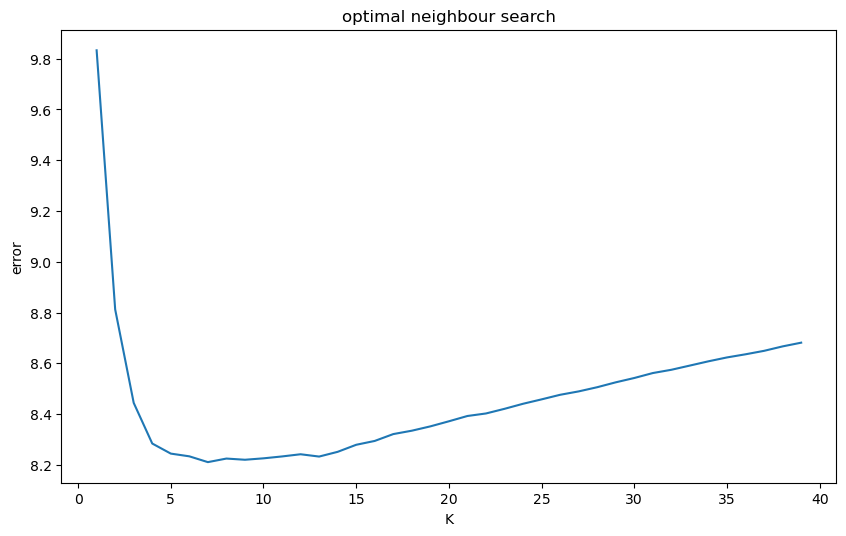

In [13]:
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(errors.keys(), errors.values())
plt.xlabel('K')
plt.ylabel('error')
plt.title('optimal neighbour search')

### Optimal K=9

In [14]:
%%time
# looking for optimal k
y= test['rating']
errors = {}
y_hat = []
for i in test.index:
    user_i, movie_j = map(int,[test.loc[i]['userId'], 
                               test.loc[i]['movieId']])
    # make the prediction here
    predicted_rating = PredictMovieRating(user_i, 
                                          movie_j, 
                                          correlation_matrix, 
                                          user_movie_rating, 9)
    y_hat.append(predicted_rating)
error_i = error(np.nan_to_num(np.array(y_hat)), y)        


CPU times: user 34.8 s, sys: 56 ms, total: 34.8 s
Wall time: 35.1 s


### MSE

In [15]:
y= test['rating'].tolist()
# compute error
error(np.nan_to_num(np.array(y_hat)), y);

In [16]:
# Pred
error(y_hat, test['rating'])

8.22011739400254

In [17]:
test['prediction'] = y_hat
test.head()

,userId,movieId,rating,prediction
25958,189,2987,2.0,1.273987
49619,362,8970,4.0,0.000000
31629,231,2183,3.0,0.000000
40289,294,908,4.5,0.670234
91856,608,831,3.0,0.000000


In [18]:
from collections import Counter
user_freq_dict = Counter(test['userId'].tolist())
max_voting = max(user_freq_dict.values())
for i in user_freq_dict:
    if user_freq_dict[i] == max_voting:
        user_choice =i

In [19]:
one_user= test.loc[(test['userId'] == user_choice)].sort_values('rating', 
                      inplace=False, 
                      ascending=False)
one_user.head()

,userId,movieId,rating,prediction
80670,547,104119,5.0,0.000000
78777,547,1295,5.0,1.179365
78612,547,924,5.0,3.683330
78768,547,1282,5.0,1.926549
79155,547,2971,5.0,0.491449


### Recall and Precision

In [20]:
relevance_threshold = 2
recommended_movies = set(one_user.loc[(one_user['prediction'] >= relevance_threshold)]['movieId'].tolist())
relavent_movies = set(one_user.loc[(one_user['rating'] >= relevance_threshold)]['movieId'].tolist())
len(relavent_movies), len(recommended_movies)

(430, 38)

In [21]:
recommended_movies_intersection_relavant_movies = [i for i in recommended_movies if i in relavent_movies]
recommended_movies_intersection_relavant_movies;

In [22]:
len(recommended_movies), len(recommended_movies_intersection_relavant_movies), len(relavent_movies)

(38, 38, 430)

In [23]:
recall = len(recommended_movies_intersection_relavant_movies)/len(relavent_movies)
precision = len(recommended_movies_intersection_relavant_movies)/len(recommended_movies)

In [24]:
precision, recall

(1.0, 0.08837209302325581)

In [25]:
f_score = 2*precision*recall/(precision+recall)
f_score

0.16239316239316237

### Recall@k and Precision@k
- recall and precision on top k predictions

In [26]:
k=18
top_k_predictions_df = one_user.sort_values('prediction', ascending=False)[:k]
top_k_predictions_df.head()

,userId,movieId,rating,prediction
78725,547,1219,5.0,4.595226
78611,547,923,5.0,4.253311
78904,547,1952,5.0,4.008699
78595,547,904,5.0,3.794107
78612,547,924,5.0,3.683330


In [27]:
relevance_threshold=3.5
top_k_movies_recommended = set(top_k_predictions_df.loc[(top_k_predictions_df['prediction'] >= relevance_threshold)]['movieId'].tolist())
top_k_movies_relevant = set(top_k_predictions_df.loc[(top_k_predictions_df['rating'] >= relevance_threshold)]['movieId'].tolist())
# top_k_predictions_df['rating']

In [28]:
recommended_movies_intersection_relavant_movies = [i for i in top_k_movies_recommended
                                                   if i in top_k_movies_relevant]
recommended_movies_intersection_relavant_movies

[1952, 1219, 904, 923, 924]

In [29]:
len(top_k_movies_recommended), len(recommended_movies_intersection_relavant_movies), len(top_k_movies_relevant)

(5, 5, 17)

In [30]:
if len(top_k_movies_relevant)!=0:
    recall = len(recommended_movies_intersection_relavant_movies)/len(top_k_movies_relevant)
else:
    recall = 1
if len(top_k_movies_recommended)!=0:
    precision = len(recommended_movies_intersection_relavant_movies)/len(top_k_movies_recommended)
else:
    precision = 1

In [31]:
precision, recall

(1.0, 0.29411764705882354)

In [32]:
f_score = 2*precision*recall/(precision+recall)
f_score

0.45454545454545453

### Making top k predictions

In [33]:
movie_meta_data_PATH= "movies_metadata.csv"
movie_df = pd.read_csv(movie_meta_data_PATH, sep= ",") # taking 100000 user-movie rating tuples
movie_df.head()

/home/ac-optimus/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [34]:
top_k_predictions_df = one_user.sort_values('prediction', ascending=False)[:k]
a=top_k_predictions_df['movieId'].unique().tolist()

In [35]:
[movie_df[movie_df.id== str(i)].title.item() for i in a if str(i) in movie_df.id.tolist()]

['Dawn of the Dead',
 'Dawn of the Dead',
 'Cool Hand Luke',
 'Ghost Rider',
 'Nell',
 'Hannibal Rising',
 'The Million Dollar Hotel',
 'The Elephant Man',
 'Meet the Robinsons',
 'Being John Malkovich']